# "Observe" the covariance matrixes
Here we use an observation matrix by TOAST for (small) SO SAT w/ 1st order poly filterings (w/o ground template)

In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy

In [2]:
PREFIX = 'scan_masked'
PREFIX_OUT = 'observed'
width_apo = 2.
apotype = 'C2'

In [3]:
nside = 64

In [4]:
Npix = hp.nside2npix(nside)
lmax = 3 * nside - 1
sigmab = hp.nside2resol(nside) 
fwhm = (8*np.log(2))**0.5 * sigmab
print('nside:{:}, Npix:{:}, res:{:.1f} deg, sigmab:{:.1f} deg'.format(nside, Npix, np.rad2deg(hp.nside2resol(nside)), np.rad2deg(sigmab)))

nside:64, Npix:49152, res:0.9 deg, sigmab:0.9 deg


In [5]:
mask = np.array(hp.read_map('{:}_nside{:03d}.fits'.format(PREFIX,nside)), dtype=bool)
unseen = ~mask
nums = np.sum(mask)
fsky = nums / mask.shape[0]
nums = int(nums) * 2
#hp.mollview(mask, title='Used mask, ring')

/home/chinoney/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home/chinoney/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 64
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/chinoney/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = RING in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/chinoney/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


## prepare mask for observation matrix 

In [6]:
idx_n2r = hp.ring2nest(nside,np.arange(Npix)[mask])
mask3 = np.hstack((idx_n2r + Npix, idx_n2r + 2*Npix))

## prepare apodization

In [7]:
invnpp = hp.read_map('./toast_telescope_all_time_all_invnpp.fits.gz', field=(0,1,2,3,4,5))

/home/chinoney/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/chinoney/.local/lib/python3.6/site-packages/healpy/fitsfunc.py:486: UserWarning: Ordering converted to RING
  warnings.warn("Ordering converted to RING")


In [8]:
def qu_weight_mineig(cc,cs,ss):
    '''
    Create a weight map using the smaller eigenvalue of the polarization matrix
    '''
    tr = cc + ss
    det = cc * ss - cs * cs
    
    val2 = tr * tr - 4 * det
    valid = (val2 > 0.0)
    val = np.zeros_like(val2)
    val[valid] = np.sqrt(val2[valid])
    
    weight = np.zeros_like(tr)
    lambda_minus = (tr - val) / 2
    valid = (lambda_minus > 0.)
    weight[valid] = lambda_minus[valid]
    
    return weight

/home/chinoney/.local/lib/python3.6/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/chinoney/.local/lib/python3.6/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_under(bgcolor)
/home/chinoney/.local/lib/python3.6/site-packages/healpy/projaxes.py:922: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a 

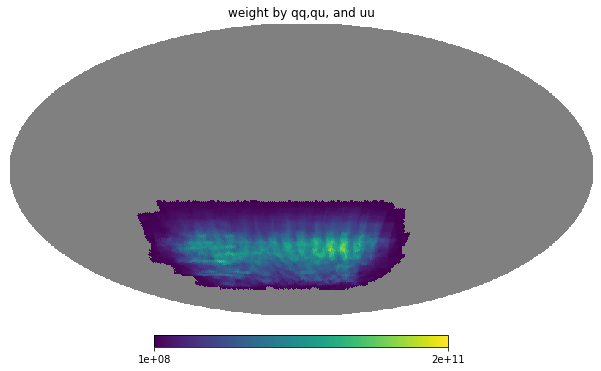

In [9]:
cc,cs,ss = invnpp[3:]
weight = np.zeros_like(mask, dtype=np.float64)
weight[mask] = qu_weight_mineig(cc,cs,ss)[mask]
hp.mollview(np.ma.masked_array(weight, mask=~mask, fill_value=hp.UNSEEN), title='weight by qq,qu, and uu',
            min=1e+8,max=2e+11)

In [10]:
!pip3 install pymaster --user

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [11]:
import pymaster as nmt

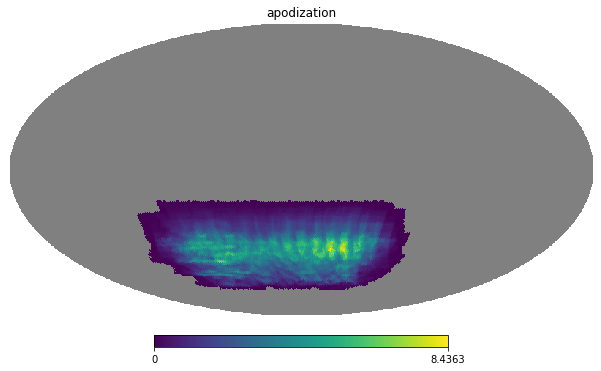

In [12]:
apo = nmt.mask_apodization(weight, aposize=width_apo, apotype=apotype)
norm = 1./ np.sqrt(np.mean(apo*apo)) 
Z = apodization = norm * apo
hp.mollview(np.ma.masked_array(apodization, mask=~mask, fill_value=hp.UNSEEN), title='apodization')
fn = '{:}_apodization_nside{:03d}.fits'.format(PREFIX, nside)
if not os.path.exists(fn):
    hp.write_map(fn, apodization)

fn = '{:}_apodization_nside{:03d}.png'.format(PREFIX, nside)
plt.savefig(fn)

In [13]:
from  scipy.sparse import diags
ZZ = diags(np.hstack((Z[mask],Z[mask])))

## prepare observation matrix

In [14]:
!ls -lha *.npz

-rw-r--r-- 1 chinoney chinoney 3.5G May 13 06:14 observed_eigen_spectrum_nside064.npz
-rw-rw---- 1 chinoney chinoney 155M May 13 02:17 toast_telescope_all_time_all_obs_matrix.npz


In [15]:
%%time
obs_matrix = scipy.sparse.load_npz('toast_telescope_all_time_all_obs_matrix.npz')[mask3][:,mask3]
obs_matrix

CPU times: user 50.8 s, sys: 1.03 s, total: 51.8 s
Wall time: 51.8 s


<15256x15256 sparse matrix of type '<class 'numpy.float64'>'
	with 8842420 stored elements in Compressed Sparse Row format>

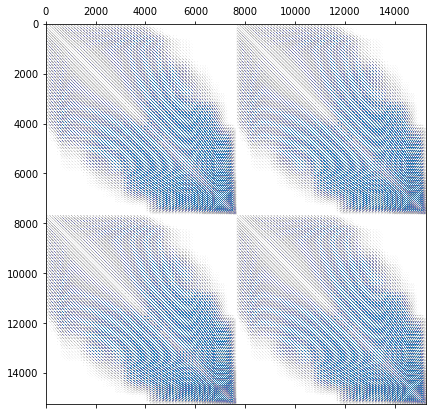

In [16]:
fig,ax = plt.subplots(1, 1, figsize=(7,7))
plt.axes(ax)
plt.spy(obs_matrix, marker='o', markersize=0.0025)
plt.savefig('obs_matrix_nside{:03d}.png'.format(nside))

## "observe" the covarinaces and save them

### apodize the observation matrix

In [17]:
%%time
obs_matrix_apo = ZZ @ obs_matrix

CPU times: user 56.4 ms, sys: 28.1 ms, total: 84.5 ms
Wall time: 83.9 ms


In [18]:
def get_cupy():
    try:
        import cupy as cp
        pool = cp.cuda.MemoryPool(cp.cuda.malloc_managed)
        cp.cuda.set_allocator(pool.malloc)
        print('Now GPU is being used!')
        return cp
    except ImportError:
        return False

def observe(obs_matrix, cov):    
    cp = get_cupy()    
    if cp:
        arr_obs_matrix = cp.sparse.csr_matrix(obs_matrix)
        arr_cov = cp.asarray(cov)
        arr_COV = arr_obs_matrix @ arr_cov @ arr_obs_matrix.T
        COV = cp.asnumpy(arr_COV)
    else:
        # takes too long if obs_matrix is sparse
        arr_obs_matrix = obs_matrix.toarray()
        COV = arr_obs_matrix @ cov @ arr_obs_matrix.T

    return COV

### do "observation"

In [19]:
%%time
for key in ('only_bb','only_ee'):
    name = '{:}_ana_cov_{:}_nisde{:03d}.npy'
    print('loading', name.format(PREFIX, key, nside))
    cov = np.load(name.format(PREFIX, key, nside))
    print('observing', name.format(PREFIX, key, nside))
    COV = observe(obs_matrix_apo, cov)
    np.save(name.format(PREFIX_OUT, key, nside), COV)

loading scan_masked_ana_cov_only_bb_nisde064.npy
observing scan_masked_ana_cov_only_bb_nisde064.npy
Now GPU is being used!
loading scan_masked_ana_cov_only_ee_nisde064.npy
observing scan_masked_ana_cov_only_ee_nisde064.npy
Now GPU is being used!
CPU times: user 3.71 s, sys: 7.31 s, total: 11 s
Wall time: 16.2 s


Note it takes 8 min w/ CPU (15 "sec" w/ GPU) for nside=64.

CPU times: user 11.4 s, sys: 4.63 s, total: 16 s
Wall time: 16 s


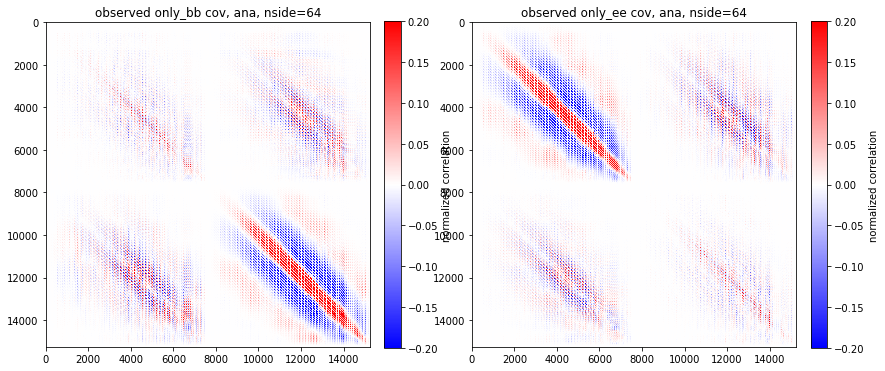

In [20]:
%%time
fig,ax = plt.subplots(1, 2, figsize=(14,7))
vmax = 1./5
for idx,key in enumerate(('only_bb','only_ee')):
    cov = np.load('{:}_ana_cov_{:}_nisde{:03d}.npy'.format(PREFIX_OUT, key, nside))
    med = np.median(cov.diagonal())

    plt.axes(ax[idx])
    plt.title('{:} {:} cov, ana, nside={:d}'.format(PREFIX_OUT, key, nside))
    im = plt.imshow(cov/med, 'bwr', interpolation=None, vmax=vmax, vmin=-vmax)
    cbr = plt.colorbar(im,fraction=0.046, pad=0.04)
    cbr.set_label('normalized correlation')
plt.savefig('{:}_normalized_corr_nside{:03d}.png'.format(PREFIX_OUT,nside))